# Forecasting using spatio-temporal data with combined Graph Convolution + LSTM model

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from libpysal.weights import Queen

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

/home/fterroso/python/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
from numpy.random import seed
seed(1)

In [3]:
data_path = os.path.join('/','home','fterroso','data','Spain-INE-mobility-study-2020')

## Loading and preprocessing the data

In [4]:
import stellargraph as sg

### Trips data

In [5]:
trips_data = pd.read_csv(os.path.join('data','trips_time_series_all_inter.csv'),index_col=0)
trips_data= trips_data.fillna(0)

In [6]:
trips_data.shape

(2844, 6815)

In [7]:
target_areas = trips_data.index.tolist()

In [8]:
trips_data.head()

,20200221_00,20200221_01,20200221_02,20200221_03,20200221_04,20200221_05,20200221_06,20200221_07,20200221_08,20200221_09,...,20201130_14,20201130_15,20201130_16,20201130_17,20201130_18,20201130_19,20201130_20,20201130_21,20201130_22,20201130_23
01001_AM,291.654,129.650,123.822,280.810,282.418,518.179,736.074,1253.000,981.544,893.510,...,1307.238,1026.083,1073.847,1147.206,650.740,648.024,563.314,735.201,258.461,230.591
01002,192.529,149.992,50.547,73.097,208.114,616.786,732.075,779.587,638.112,734.767,...,701.593,598.760,615.822,826.882,580.843,378.512,381.695,407.566,124.729,106.744
01010_AM,92.726,50.822,37.895,19.586,91.560,396.531,457.180,591.326,516.919,471.008,...,495.460,610.121,559.796,476.880,354.807,215.711,216.593,277.574,119.830,52.331
01031_AM,97.674,64.901,92.150,62.669,109.056,208.462,469.924,691.565,645.793,789.906,...,1085.613,628.526,682.578,582.456,603.958,344.157,286.541,269.655,159.443,118.029
01036,173.565,118.227,204.784,219.318,409.485,779.103,1091.613,969.506,845.084,875.701,...,1070.542,815.612,681.116,746.917,704.784,413.711,441.988,575.437,319.760,68.968


In [9]:
trips_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2844 entries, 01001_AM to 20903
Columns: 6815 entries, 20200221_00 to 20201130_23
dtypes: float64(6815)
memory usage: 147.9+ MB


### Zones data

In [10]:
zones_gdf = gpd.read_file(os.path.join(data_path,'zonificacion','distritos_mitma.shp'))

In [11]:
zones_gdf = zones_gdf[zones_gdf['ID'].isin(target_areas)]

In [12]:
zones_gdf.head()

,ID,geometry
0,2408910,"POLYGON ((290940.137 4719080.203, 290956.704 4..."
1,22117_AM,"POLYGON ((774184.362 4662152.523, 774452.348 4..."
2,2305009,"POLYGON ((429744.982 4179976.538, 429716.997 4..."
3,07058_AM,"POLYGON ((1000859.396 4415059.160, 1000625.088..."
4,2305006,"POLYGON ((429795.125 4180956.539, 429860.816 4..."


In [13]:
zones_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2844 entries, 0 to 2849
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ID        2844 non-null   object  
 1   geometry  2844 non-null   geometry
dtypes: geometry(1), object(1)
memory usage: 66.7+ KB


## Define adjacency/distance matrix

In [14]:
def get_adj_matrix_fn(type_):
    matrix_ = None
    if type_=='distance':
        matrix_ = pd.read_csv(os.path.join('data', 'distances.csv'), index_col=0)
        matrix_ = matrix_.loc[target_areas][target_areas].values
    elif type_ =='contiguity': #contiguity matrix
        qW = Queen.from_dataframe(zones_gdf)
        matrix_ = 1- qW.full()[0]
    elif type_ == 'gravity_model':
        matrix_ = pd.read_csv(os.path.join('data', 'gravity_model_adjacency_matrix.csv'), index_col=0)
        matrix_ = matrix_.replace(0,1)
        matrix_ = matrix_.loc[target_areas][target_areas].values
        #matrix_ = 1- (matrix_ / matrix_.max().max())
        np.fill_diagonal(matrix_,0)
    elif type_== 'ylag':
        matrix_ = pd.read_csv(os.path.join('data', 'ylag_adjacency_matrix.csv'), index_col=0)
        matrix_ = matrix_.loc[target_areas][target_areas].values
    elif type_== 'queen_gravity_model':
        matrix_ = pd.read_csv(os.path.join('data', 'queen_gravity_model_adjacency_matrix.csv'), index_col=0)
        matrix_ = matrix_.loc[target_areas][target_areas].values

    return matrix_

In [15]:
matrix_type= 'gravity_model' #or 'distance', 'gravity_model', 'contiguity', 'ylag', 'queen_gravity_model'

In [16]:
adj_matrix = get_adj_matrix_fn(matrix_type)

In [17]:
adj_matrix.shape

(2844, 2844)

In [18]:
adj_matrix

array([[      0.        , 1218677.80845929,  561558.35994315, ...,
         131247.88529629,  277414.75121167,  576387.56364082],
       [1218677.80845929,       0.        , 3820727.944408  , ...,
         190572.74929374,  271063.17189818,  540695.29452607],
       [ 561558.35994315, 3820727.944408  ,       0.        , ...,
         106475.47664812,  145318.44188452,  288036.58955808],
       ...,
       [ 131247.88529629,  190572.74929374,  106475.47664812, ...,
              0.        ,   67255.77650498,   86118.33791093],
       [ 277414.75121167,  271063.17189818,  145318.44188452, ...,
          67255.77650498,       0.        ,  327733.65488228],
       [ 576387.56364082,  540695.29452607,  288036.58955808, ...,
          86118.33791093,  327733.65488228,       0.        ]])

In [19]:
#speed_data, sensor_dist_adj = dataset.load()
num_nodes, time_len = trips_data.shape
print("No. of areas:", num_nodes, "\nNo of timesteps:", time_len)

No. of areas: 2844 
No of timesteps: 6815


**Let's look at a sample of human mobility data data.**

In [20]:
trips_data.head()

,20200221_00,20200221_01,20200221_02,20200221_03,20200221_04,20200221_05,20200221_06,20200221_07,20200221_08,20200221_09,...,20201130_14,20201130_15,20201130_16,20201130_17,20201130_18,20201130_19,20201130_20,20201130_21,20201130_22,20201130_23
01001_AM,291.654,129.650,123.822,280.810,282.418,518.179,736.074,1253.000,981.544,893.510,...,1307.238,1026.083,1073.847,1147.206,650.740,648.024,563.314,735.201,258.461,230.591
01002,192.529,149.992,50.547,73.097,208.114,616.786,732.075,779.587,638.112,734.767,...,701.593,598.760,615.822,826.882,580.843,378.512,381.695,407.566,124.729,106.744
01010_AM,92.726,50.822,37.895,19.586,91.560,396.531,457.180,591.326,516.919,471.008,...,495.460,610.121,559.796,476.880,354.807,215.711,216.593,277.574,119.830,52.331
01031_AM,97.674,64.901,92.150,62.669,109.056,208.462,469.924,691.565,645.793,789.906,...,1085.613,628.526,682.578,582.456,603.958,344.157,286.541,269.655,159.443,118.029
01036,173.565,118.227,204.784,219.318,409.485,779.103,1091.613,969.506,845.084,875.701,...,1070.542,815.612,681.116,746.917,704.784,413.711,441.988,575.437,319.760,68.968


In [21]:
trips_data.isnull().values.any()

False

### Forecasting with spatio-temporal data as a supervised learning problem 

### Train/test split

In [22]:
def train_test_split(data, train_portion):
    time_len = data.shape[1]
    train_size = int(time_len * train_portion)
    train_data = np.array(data.iloc[:, :train_size])
    test_data = np.array(data.iloc[:, train_size:])
    return train_data, test_data

In [23]:
train_rate = 0.9

In [24]:
train_data, test_data = train_test_split(trips_data, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

Train data:  (2844, 6133)
Test data:  (2844, 682)


### Scaling

In [25]:
def scale_data(train_data, test_data):
    max_speed = train_data.max()
    min_speed = train_data.min()
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    return train_scaled, test_scaled

In [26]:
train_scaled, test_scaled = scale_data(train_data, test_data)

### Sequence data preparation for LSTM

* Each training observation are 12 historical outgoing trips (`seq_len`).
* Each training prediction is the number of outgoing trips 1 hour later (`pre_len`).

In [27]:
seq_len = 12
pre_len = 1

In [28]:
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [29]:
trainX, trainY, testX, testY = sequence_data_preparation(
    seq_len, pre_len, train_scaled, test_scaled
)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(6121, 2844, 12)
(6121, 2844)
(670, 2844, 12)
(670, 2844)


## StellarGraph Graph Convolution and LSTM model

In [30]:
from stellargraph.layer import GCN_LSTM

In [31]:
import sys

In [32]:
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=adj_matrix,
    gc_layer_sizes=[16, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200, 200],
    lstm_activations=["tanh", "tanh"],
)


/home/fterroso/python/lib/python3.6/site-packages/ipykernel_launcher.py:20: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.


In [33]:
adj_matrix.shape

(2844, 2844)

In [34]:
x_input, x_output = gcn_lstm.in_out_tensors()

In [35]:
model = Model(inputs=x_input, outputs=x_output)

In [36]:
model.compile(optimizer="adam", loss="mae", metrics=["mse"])

In [37]:
trainX.shape

(6121, 2844, 12)

In [38]:
testX.shape

(670, 2844, 12)

In [39]:
history = model.fit(
    trainX,
    trainY,
    epochs=400,
    batch_size=60,
    shuffle=True,
    validation_data=(testX, testY),
)

Epoch 1/400
103/103 [==============================] - 24s 199ms/step - loss: 0.1823 - mse: 0.0742 - val_loss: 0.0099 - val_mse: 3.6440e-04
Epoch 2/400
103/103 [==============================] - 20s 191ms/step - loss: 0.0096 - mse: 3.4476e-04 - val_loss: 0.0097 - val_mse: 3.5114e-04
Epoch 3/400
103/103 [==============================] - 21s 200ms/step - loss: 0.0095 - mse: 3.2820e-04 - val_loss: 0.0098 - val_mse: 3.8564e-04
Epoch 4/400
103/103 [==============================] - 21s 202ms/step - loss: 0.0092 - mse: 3.2214e-04 - val_loss: 0.0094 - val_mse: 3.3301e-04
Epoch 5/400
103/103 [==============================] - 21s 203ms/step - loss: 0.0092 - mse: 3.1076e-04 - val_loss: 0.0096 - val_mse: 3.6939e-04
Epoch 6/400
103/103 [==============================] - 20s 199ms/step - loss: 0.0090 - mse: 2.9863e-04 - val_loss: 0.0094 - val_mse: 3.5091e-04
Epoch 7/400
103/103 [==============================] - 21s 201ms/step - loss: 0.0090 - mse: 2.9301e-04 - val_loss: 0.0095 - val_mse: 3.5440e

103/103 [==============================] - 20s 198ms/step - loss: 0.0036 - mse: 4.1216e-05 - val_loss: 0.0032 - val_mse: 4.6579e-05
Epoch 114/400
103/103 [==============================] - 21s 200ms/step - loss: 0.0036 - mse: 4.0939e-05 - val_loss: 0.0035 - val_mse: 5.9081e-05
Epoch 115/400
103/103 [==============================] - 20s 198ms/step - loss: 0.0036 - mse: 4.1550e-05 - val_loss: 0.0029 - val_mse: 3.3732e-05
Epoch 116/400
103/103 [==============================] - 20s 198ms/step - loss: 0.0035 - mse: 4.0112e-05 - val_loss: 0.0029 - val_mse: 3.8228e-05
Epoch 117/400
103/103 [==============================] - 20s 199ms/step - loss: 0.0035 - mse: 4.0461e-05 - val_loss: 0.0035 - val_mse: 4.1431e-05
Epoch 118/400
103/103 [==============================] - 20s 198ms/step - loss: 0.0038 - mse: 4.6516e-05 - val_loss: 0.0030 - val_mse: 3.4289e-05
Epoch 119/400
103/103 [==============================] - 20s 198ms/step - loss: 0.0036 - mse: 4.1281e-05 - val_loss: 0.0029 - val_mse: 3.1

103/103 [==============================] - 20s 198ms/step - loss: 0.0026 - mse: 2.3263e-05 - val_loss: 0.0028 - val_mse: 3.5350e-05
Epoch 226/400
103/103 [==============================] - 20s 198ms/step - loss: 0.0025 - mse: 2.2908e-05 - val_loss: 0.0027 - val_mse: 2.6708e-05
Epoch 227/400
103/103 [==============================] - 20s 198ms/step - loss: 0.0025 - mse: 2.1753e-05 - val_loss: 0.0027 - val_mse: 2.6425e-05
Epoch 228/400
103/103 [==============================] - 20s 199ms/step - loss: 0.0026 - mse: 2.2945e-05 - val_loss: 0.0026 - val_mse: 2.7115e-05
Epoch 229/400
103/103 [==============================] - 21s 200ms/step - loss: 0.0025 - mse: 2.2214e-05 - val_loss: 0.0026 - val_mse: 2.7659e-05
Epoch 230/400
103/103 [==============================] - 20s 197ms/step - loss: 0.0025 - mse: 2.1667e-05 - val_loss: 0.0028 - val_mse: 3.3148e-05
Epoch 231/400
103/103 [==============================] - 21s 201ms/step - loss: 0.0025 - mse: 2.3836e-05 - val_loss: 0.0028 - val_mse: 2.7

103/103 [==============================] - 21s 200ms/step - loss: 0.0021 - mse: 1.6336e-05 - val_loss: 0.0023 - val_mse: 2.1774e-05
Epoch 338/400
103/103 [==============================] - 20s 199ms/step - loss: 0.0020 - mse: 1.5629e-05 - val_loss: 0.0024 - val_mse: 2.2124e-05
Epoch 339/400
103/103 [==============================] - 20s 199ms/step - loss: 0.0020 - mse: 1.5342e-05 - val_loss: 0.0024 - val_mse: 2.3839e-05
Epoch 340/400
103/103 [==============================] - 20s 197ms/step - loss: 0.0021 - mse: 1.6447e-05 - val_loss: 0.0023 - val_mse: 2.1173e-05
Epoch 341/400
103/103 [==============================] - 20s 198ms/step - loss: 0.0020 - mse: 1.6175e-05 - val_loss: 0.0024 - val_mse: 2.2038e-05
Epoch 342/400
103/103 [==============================] - 20s 198ms/step - loss: 0.0020 - mse: 1.5636e-05 - val_loss: 0.0024 - val_mse: 2.1324e-05
Epoch 343/400
103/103 [==============================] - 20s 199ms/step - loss: 0.0020 - mse: 1.6051e-05 - val_loss: 0.0024 - val_mse: 2.2

In [40]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2844, 12)]        0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 2844, 12, 1)       0         
_________________________________________________________________
reshape (Reshape)            (None, 2844, 12)          0         
_________________________________________________________________
fixed_adjacency_graph_convol (None, 2844, 16)          8091372   
_________________________________________________________________
fixed_adjacency_graph_convol (None, 2844, 10)          8091340   
_________________________________________________________________
reshape_1 (Reshape)          (None, 2844, 10, 1)       0         
_________________________________________________________________
permute (Permute)            (None, 10, 2844, 1)       0     

In [41]:
print(
    "Train loss: ",
    history.history["loss"][-1],
    "\nTest loss:",
    history.history["val_loss"][-1],
)

Train loss:  0.00198770291171968 
Test loss: 0.0023099237587302923


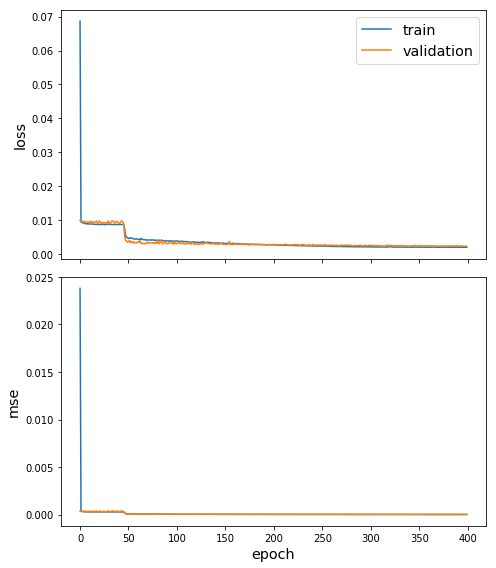

In [42]:
sg.utils.plot_history(history)

In [43]:
ythat = model.predict(trainX)
yhat = model.predict(testX)

## Rescale values

Rescale the predicted values to the original value range of the timeseries.

In [44]:
## Rescale values
max_speed = train_data.max()
min_speed = train_data.min()

## actual train and test values
train_rescref = np.array(trainY * max_speed)
test_rescref = np.array(testY * max_speed)

In [45]:
## Rescale model predicted values
train_rescpred = np.array((ythat) * max_speed)
test_rescpred = np.array((yhat) * max_speed)

In [46]:
print(train_rescpred.shape, test_rescpred.shape)

(6121, 2844) (670, 2844)


## Measuring the performance of the model

### Naive prediction benchmark (using latest observed value)

In [47]:

testnpred = np.array(testX)[
    :, :, -1
]  # picking the last speed of the 10 sequence for each segment in each sample
testnpredc = (testnpred) * max_speed

In [48]:
print(test_rescref.shape, test_rescpred.shape)

(670, 2844) (670, 2844)


In [49]:
testX.shape[-1]

12

In [50]:
test_rescref.T.shape

(2844, 670)

In [51]:
test_rescref.T[0].shape

(670,)

In [52]:
test_rescpred.T.shape

(2844, 670)

In [53]:
test_metrics = []

for j in range(testX.shape[-2]):
    gnn_mae_ = mean_absolute_error(test_rescref.T[j], test_rescpred.T[j])
    gnn_mse_ = mean_squared_error(test_rescref.T[j], test_rescpred.T[j])
    gnn_rmse_ = mean_squared_error(test_rescref.T[j], test_rescpred.T[j], squared = False)
    
    naive_mae_ = mean_absolute_error(test_rescref.T[j], testnpredc.T[j])
    naive_mse_ = mean_squared_error(test_rescref.T[j], testnpredc.T[j])
    naive_rmse_ = mean_squared_error(test_rescref.T[j], testnpredc.T[j], squared = False) 
    
    test_metrics.append((trips_data.iloc[j].name, gnn_mae_, gnn_mse_, gnn_rmse_, naive_mae_, naive_mse_, naive_rmse_))


In [54]:
test_metrics_df = pd.DataFrame.from_records(test_metrics, 
                                            columns='area_id gnn-MAE gnn-MSE gnn-RMSE naive-MAE naive-MSE naive-RMSE'.split())

In [55]:
test_metrics_df.head()

,area_id,gnn-MAE,gnn-MSE,gnn-RMSE,naive-MAE,naive-MSE,naive-RMSE
0,01001_AM,97.028504,18698.806028,136.743578,156.029249,45910.420469,214.267171
1,01002,77.622980,10563.873059,102.780704,119.004543,24503.809545,156.536927
2,01010_AM,66.552801,8167.135691,90.372206,99.341722,18573.031657,136.282910
3,01031_AM,112.686855,23646.023189,153.772635,111.199473,22496.806037,149.989353
4,01036,112.154167,21547.425136,146.790412,146.149875,39890.098894,199.725058


In [56]:
test_metrics_df.shape

(2844, 7)

In [57]:
test_metrics_df.to_csv(os.path.join('data', 'gnn_naive_test_metrics_{}.csv'.format(matrix_type)))

In [58]:
## Performance measures

seg_mael = []
seg_masel = []
seg_nmael = []

for j in range(testX.shape[-1]):

    seg_mael.append(
        np.mean(np.abs(test_rescref.T[j] - test_rescpred.T[j]))
    )  # Mean Absolute Error for NN
    seg_nmael.append(
        np.mean(np.abs(test_rescref.T[j] - testnpredc.T[j]))
    )  # Mean Absolute Error for naive prediction
    if seg_nmael[-1] != 0:
        seg_masel.append(
            seg_mael[-1] / seg_nmael[-1]
        )  # Ratio of the two: Mean Absolute Scaled Error
    else:
        seg_masel.append(np.NaN)

print("Total (ave) MAE for NN: " + str(np.mean(np.array(seg_mael))))
print("Total (ave) MAE for naive prediction: " + str(np.mean(np.array(seg_nmael))))
print(
    "Total (ave) MASE for per-segment NN/naive MAE: "
    + str(np.nanmean(np.array(seg_masel)))
)
print(
    "...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction."
)

Total (ave) MAE for NN: 139.65429948830675
Total (ave) MAE for naive prediction: 240.0559539800995
Total (ave) MASE for per-segment NN/naive MAE: 0.6854885348666154
...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction.


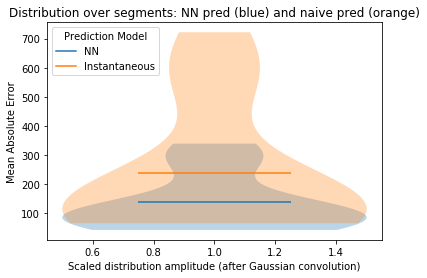

In [59]:
# plot violin plot of MAE for naive and NN predictions
fig, ax = plt.subplots()
# xl = minsl

ax.violinplot(
    list(seg_mael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

ax.violinplot(
    list(seg_nmael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

line1 = mlines.Line2D([], [], label="NN")
line2 = mlines.Line2D([], [], color="C1", label="Instantaneous")

ax.set_xlabel("Scaled distribution amplitude (after Gaussian convolution)")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Distribution over segments: NN pred (blue) and naive pred (orange)")
plt.legend(handles=(line1, line2), title="Prediction Model", loc=2)
plt.show()

#### Plot of actual and predicted outgoing trips on a sample MA

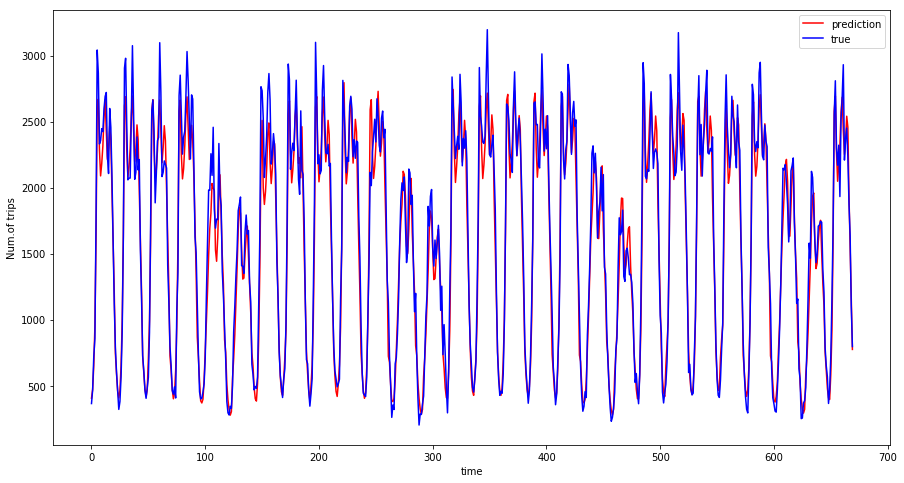

In [60]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = test_rescpred[:, 20]
a_true = test_rescref[:, 20]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("time")
plt.ylabel("Num.of trips")
plt.legend(loc="best", fontsize=10)
plt.show()

#### Plot of actual and predicted outgoing trips from Spain

In [61]:
test_rescpred_df =pd.DataFrame(test_rescpred).T
test_rescref_df =pd.DataFrame(test_rescref).T

In [62]:
test_rescpred_df.loc['total']= test_rescpred_df.sum(axis=0)
test_rescref_df.loc['total']= test_rescref_df.sum(axis=0)

In [63]:
test_rescpred_df.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,660,661,662,663,664,665,666,667,668,669
2842,3.393614e+00,5.227687e+00,2.100592e+01,5.840582e+01,9.562261e+01,1.016797e+02,9.768353e+01,1.351947e+02,1.479498e+02,1.469786e+02,...,8.065044e+01,1.309778e+02,1.490467e+02,1.497020e+02,1.017784e+02,6.589909e+01,3.075398e+01,1.911016e+01,1.245527e+01,2.391516e+00
2843,1.642350e-08,4.790803e-08,2.985816e-06,2.231154e-04,2.774638e-02,1.687714e+00,4.067307e+00,8.487820e+00,9.257971e+00,1.208365e+01,...,2.537534e+00,9.735500e+00,1.189336e+01,1.034408e+01,6.258662e+00,3.463119e+00,5.006306e-01,6.597226e-02,3.914164e-03,1.101110e-05
total,7.801235e+05,9.067448e+05,1.290275e+06,1.873736e+06,3.070585e+06,4.703642e+06,4.903812e+06,4.356148e+06,4.076291e+06,4.266393e+06,...,5.660836e+06,5.002108e+06,4.619662e+06,4.906812e+06,5.141929e+06,4.787308e+06,3.750224e+06,3.026360e+06,2.268822e+06,1.446574e+06


In [64]:
test_rescref_df.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,660,661,662,663,664,665,666,667,668,669
2842,0.000,13.482,78.649,117.685,164.973,149.283,271.321,145.313,40.938,199.951,...,280.769,263.079,312.210,233.029,58.550,178.702,64.342,9.760,11.840,0.000
2843,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
total,797509.599,868282.061,1225825.058,2065455.666,3159665.704,4794189.252,4950684.439,4370690.021,4124186.980,4294147.600,...,5832511.146,5060517.688,4719101.508,4925188.213,4992998.135,4451594.013,3834109.629,3071823.504,2149818.919,1210790.486


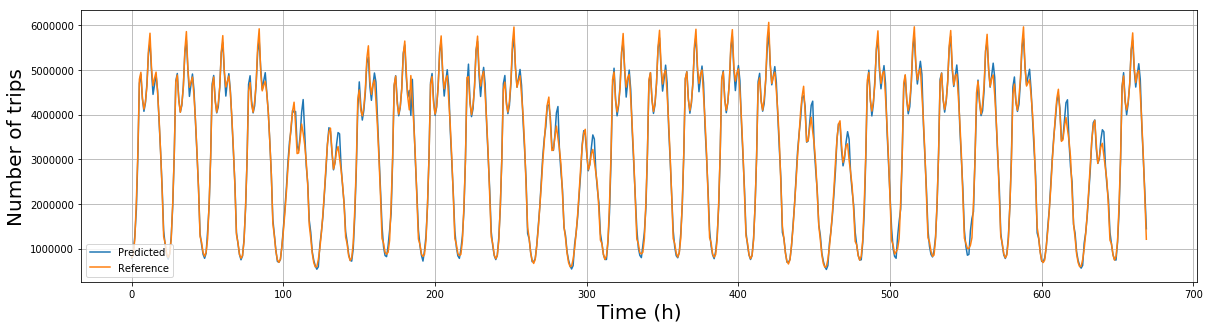

In [67]:
ax=test_rescpred_df.loc['total'].plot(figsize=(20,5), label='Predicted')
test_rescref_df.loc['total'].plot(ax=ax, grid=True, label='Reference')
ax.set_ylabel('Number of trips')
ax.set_xlabel('Time (h)')
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.legend(loc='lower left');
plt.savefig(os.path.join('figs','true_vs_predicted_global.png'))

In [66]:
print("That's all folks")

That's all folks
